## Introduction to Machine Learning Tutorial
#### Danqi Wang

breast cancer dataset

## I. Preparation for DATA

### 1. import library

In [60]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve,confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### 2. load data

In [2]:
original_data = '/Users/wangdanqi/Desktop/breast-cancer-wisconsin.data'
data = pd.read_csv(original_data, header = None, na_values = ['?'])
data.columns= ['id', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 
               'Marginal Adhesion','Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
               'Normal Nucleoli', 'Mitoses', 'Class']
data.info()
data.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           699 non-null    int64  
 1   Clump Thickness              699 non-null    int64  
 2   Uniformity of Cell Size      699 non-null    int64  
 3   Uniformity of Cell Shape     699 non-null    int64  
 4   Marginal Adhesion            699 non-null    int64  
 5   Single Epithelial Cell Size  699 non-null    int64  
 6   Bare Nuclei                  683 non-null    float64
 7   Bland Chromatin              699 non-null    int64  
 8   Normal Nucleoli              699 non-null    int64  
 9   Mitoses                      699 non-null    int64  
 10  Class                        699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


id                             False
Clump Thickness                False
Uniformity of Cell Size        False
Uniformity of Cell Shape       False
Marginal Adhesion              False
Single Epithelial Cell Size    False
Bare Nuclei                     True
Bland Chromatin                False
Normal Nucleoli                False
Mitoses                        False
Class                          False
dtype: bool

In [3]:
# drop rows with '?'
df = data.dropna(axis = 0)
new_data = df.iloc[:,1:]
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump Thickness              683 non-null    int64  
 1   Uniformity of Cell Size      683 non-null    int64  
 2   Uniformity of Cell Shape     683 non-null    int64  
 3   Marginal Adhesion            683 non-null    int64  
 4   Single Epithelial Cell Size  683 non-null    int64  
 5   Bare Nuclei                  683 non-null    float64
 6   Bland Chromatin              683 non-null    int64  
 7   Normal Nucleoli              683 non-null    int64  
 8   Mitoses                      683 non-null    int64  
 9   Class                        683 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 58.7 KB


## II. Analyze features

### 1. correlation heatmap

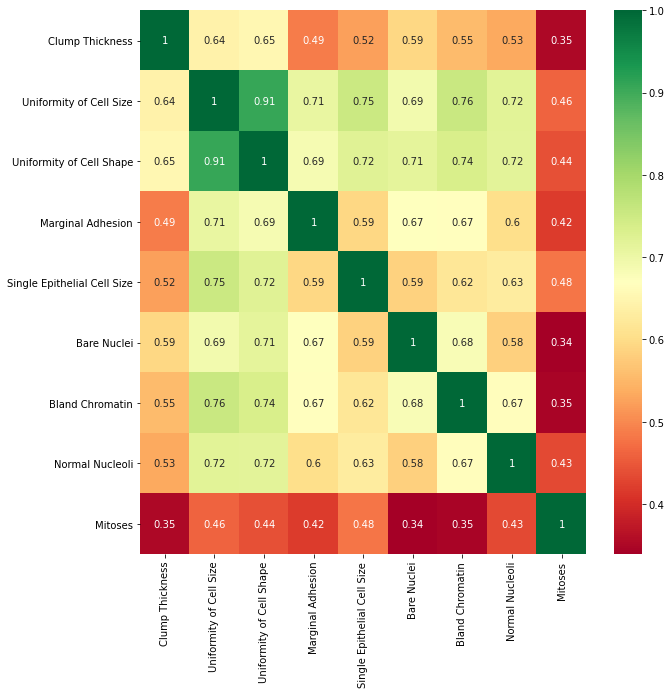

In [17]:
feature = new_data.iloc[:,:-1]
label = new_data.iloc[:,-1].replace({2: 0, 4: 1})

plt.figure(figsize=(10,10))
g = sns.heatmap(feature.corr(method = 'pearson'), annot = True, cmap = 'RdYlGn')

### Result from heatmap:
   'Uniformity of Cell Size' and 'Uniformity of Cell Shape'are interdependent features. For other features, there is no multicollinearity among them. 

### 2. Density Plot

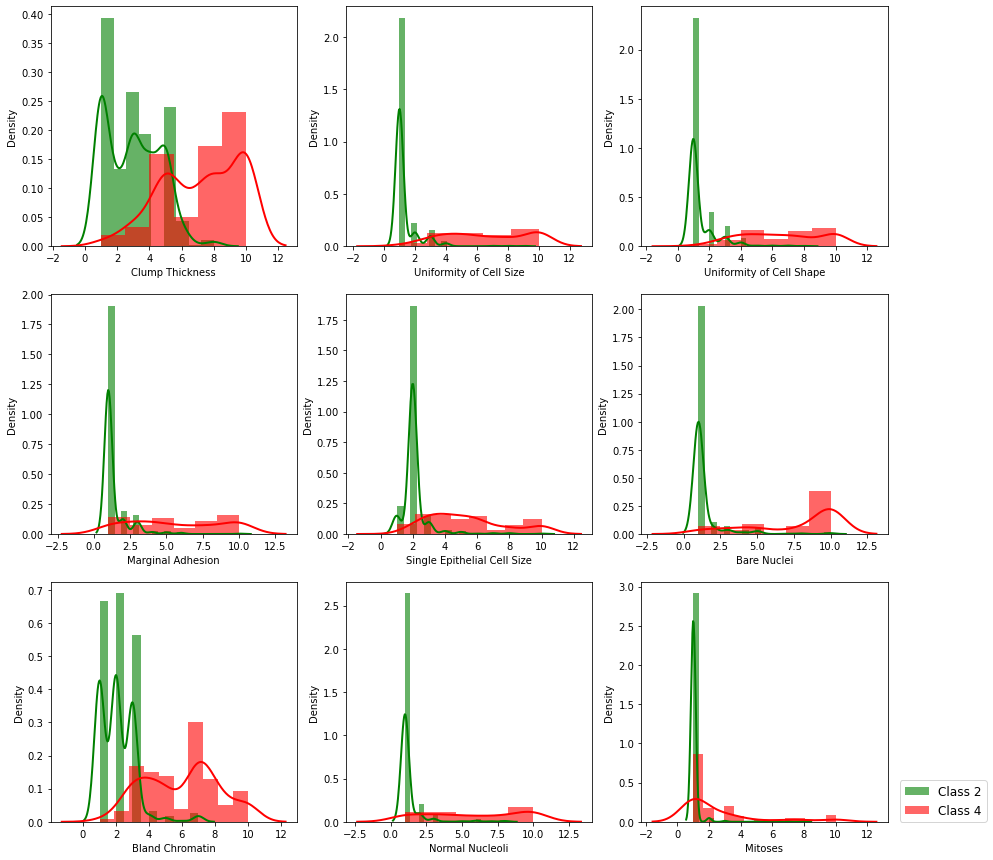

In [148]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,15))
for i, name in enumerate(feature.columns, 1):
    x1 = new_data.loc[new_data['Class'] == 2, name]
    x2 = new_data.loc[new_data['Class'] == 4, name]
    
    kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
    
    plt.subplot(3, 3, i)
    sns.distplot(x1, **kwargs, color='g', label='Class 2')
    sns.distplot(x2, **kwargs, color='r', label='Class 4')
plt.legend(fontsize = 12, bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

### Result from histogram:
   Three features: 'Bare Nuclei', 'Uniformity of Cell Size' and 'Uniformity of Cell Shape', have less overlap between two classes. ALL of them might be of great importance.
    

## III. Split data

In [5]:
# Creating train and test set
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size = 0.15, random_state = 42, stratify = label)

## IV. Decision Tree on raw data

In [110]:
tree = DecisionTreeClassifier()
p_tree = {
    'criterion': ('gini','entropy'),
    'min_samples_split': range(200,1001,200),
    'max_depth': range(5,15,2),
    'min_samples_leaf': range(1,20,5),
    'max_features': ['log2','sqrt']}

tree_ = GridSearchCV(estimator = tree, param_grid = p_tree, 
                   cv = 5,
                   n_jobs = -1, 
                   verbose = 0)
tree_model = tree_.fit(x_train, y_train)

In [166]:
model_list_tree = ['Decision Tree: raw data', tree_model]

In [167]:
stat_dict = {}
def statistic(model_name, model, x_test, y_test):
    # get result of train set
    print('best score of model:', model.best_score_, '\n\n')
    print('best parameters of model:', model.best_params_, '\n\n')
    df_cv_scores = pd.DataFrame(model.cv_results_)
    select_df = df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    print(select_df.sort_values(by='rank_test_score')[:6],'\n\n')
    
    pred = model.predict(x_test)

    # get prediction results
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auroc = roc_auc_score(y_test, pred)
    
    print('Prediction results:')
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1))
    print('AUROC score: {:.2f}'.format(auroc))
    
    stat_dict[model_name] = [accuracy, precision, recall, f1, auroc]
    print(stat_dict)
    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

best score of model: 0.9448275862068967 


best parameters of model: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 200} 


                                                params  split0_test_score  \
25   {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.931034   
250  {'criterion': 'entropy', 'max_depth': 7, 'max_...           0.931034   
145  {'criterion': 'gini', 'max_depth': 11, 'max_fe...           0.939655   
90   {'criterion': 'gini', 'max_depth': 9, 'max_fea...           0.922414   
80   {'criterion': 'gini', 'max_depth': 9, 'max_fea...           0.922414   
125  {'criterion': 'gini', 'max_depth': 11, 'max_fe...           0.922414   

     split1_test_score  split2_test_score  split3_test_score  \
25            0.931034           0.982759           0.965517   
250           0.931034           0.948276           0.948276   
145           0.939655           0.948276           0.965517   
90            0.93103

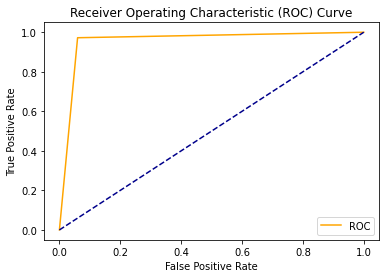

In [168]:
model_name = model_list_tree[0]
model = model_list_tree[1]
statistic(model_name, model, x_test, y_test)

## V. Ensemble method -  RandomForest on raw data

In [6]:
RF = RandomForestClassifier()
p_rf = {
    'n_estimators': [50,100,200,300],
    'min_samples_split': range(200,1001,200),
    'max_depth': range(5,15,2),
    'min_samples_leaf': range(1,20,5),
    'max_features': ['log2','sqrt']}

rff = GridSearchCV(estimator = RF, param_grid = p_rf, 
                   cv = 5,
                   n_jobs = -1, 
                   verbose = 0)
rf_model = rff.fit(x_train, y_train)


best score of model: 0.9672413793103448 


best parameters of model: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 11, 'min_samples_split': 200, 'n_estimators': 200} 


                                                params  split0_test_score  \
262  {'max_depth': 7, 'max_features': 'sqrt', 'min_...           0.982759   
42   {'max_depth': 5, 'max_features': 'log2', 'min_...           0.991379   
520  {'max_depth': 11, 'max_features': 'log2', 'min...           0.991379   
502  {'max_depth': 11, 'max_features': 'log2', 'min...           0.982759   
482  {'max_depth': 11, 'max_features': 'log2', 'min...           0.982759   
501  {'max_depth': 11, 'max_features': 'log2', 'min...           0.982759   

     split1_test_score  split2_test_score  split3_test_score  \
262           0.956897           0.982759           0.965517   
42            0.956897           0.991379           0.965517   
520           0.956897           0.982759           0.956897   
502           0.9568

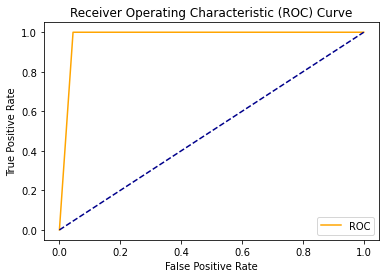

In [171]:
model_list_forest = ['Random Forest: raw data', rf_model]
statistic(model_list_forest[0], model_list_forest[1], x_test, y_test)

### plot permutation feature importance

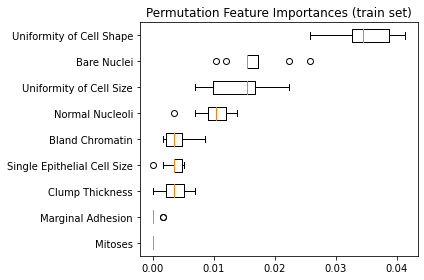

In [129]:
def perm_feature(model):

    result = permutation_importance(model, x_train, y_train, n_repeats=10,random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = x_train.columns[sorted_idx])
    ax.set_title("Permutation Feature Importances (train set)")
    fig.tight_layout()
    plt.show()
    
perm_feature(rf_model)

### Result of Random Forest:

1. Best parameters of model: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 11, 'min_samples_split': 200, 'n_estimators': 200}.


2. Prediction results:
Accuracy: 0.97
Precision: 0.92
Recall: 1.00
F1 score: 0.96
AUROC score: 0.98


3. Uniformity of Cell Shape, Bare Nuclei and Uniformity of Cell shape are the top important features. Mitoses and Marginal Adhesion are the features with least importance.



## Ensemble method -  Gradient Boosting on raw data

In [10]:
p_gb = {
    "loss":["deviance"], 
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 20, 30]}

gb = GridSearchCV(estimator = GradientBoostingClassifier(), 
                  param_grid = p_gb, 
                  cv = 5, 
                  verbose = 0, 
                  n_jobs=-1)
gb_model = gb.fit(x_train, y_train)

best score of model: 0.9810344827586206 


best parameters of model: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.42727272727272736, 'n_estimators': 30, 'subsample': 0.8} 


                                                  params  split0_test_score  \
79081  {'criterion': 'friedman_mse', 'learning_rate':...           0.991379   
75742  {'criterion': 'friedman_mse', 'learning_rate':...           1.000000   
81811  {'criterion': 'friedman_mse', 'learning_rate':...           0.991379   
87860  {'criterion': 'friedman_mse', 'learning_rate':...           0.991379   
75851  {'criterion': 'friedman_mse', 'learning_rate':...           0.991379   
54619  {'criterion': 'friedman_mse', 'learning_rate':...           0.991379   

       split1_test_score  split2_test_score  split3_test_score  \
79081           0.965517                1.0           0.982759   
75742    

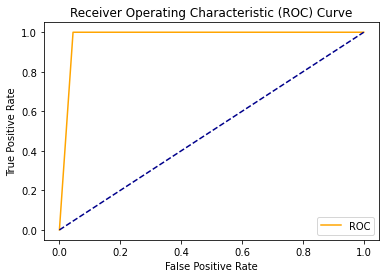

In [172]:
model_list_gb = ['Gradient Boosting: raw data', gb_model]
statistic(model_list_gb[0], model_list_gb[1], x_test, y_test)

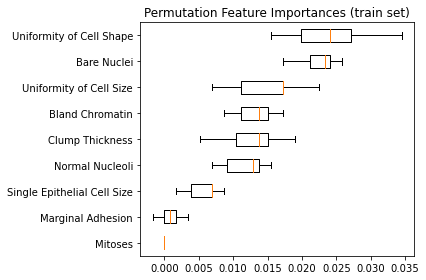

In [131]:
perm_feature(gb_model)

### Result of Gradient Boosting:
Uniformity of Cell Shape, Bare Nuclei and Uniformity of Cell Size are the top three features with high importance value.

## VI.Data processing 

### 1. check outliers

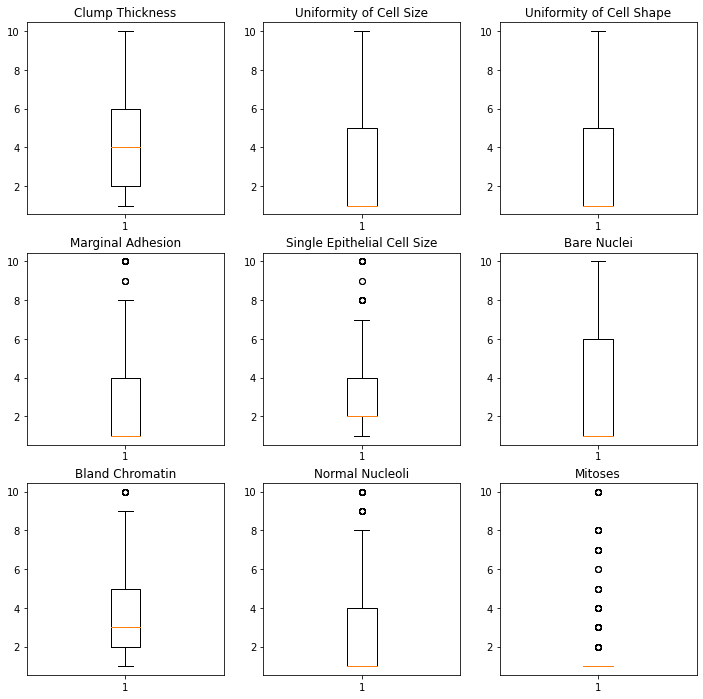

In [53]:
plt.figure(figsize=(12,12))
for i, name in enumerate(feature.columns, 1):
    plt.subplot(3, 3, i)
    plt.title(name)
    plt.boxplot(feature[name])

In [82]:
z_scores = stats.zscore(new_data)
print(new_data.shape)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_data[filtered_entries]
print(new_df.shape)

(683, 10)
(632, 10)


##### Result: delete 51 rows with outliers

### 2. Create new feature and label sets

In [94]:
feature_new = new_df.iloc[:,:-1]
label_new = new_df.iloc[:,-1].replace({2: 0, 4: 1})

### 3. Decorrelation: PCA

#### HIGH correlated features: uniformity of Cell Size and Cell Shape

In [95]:
pca = PCA(n_components=0.99) #set 95% of variance 
pca.fit(feature_new.values) 
print(pca.explained_variance_ratio_) # get the ratio of each component 
print(pca.n_components_) # get the number of components

[0.69905172 0.08095611 0.06815486 0.04412901 0.04015232 0.02972311
 0.01783155 0.01263974]
8


In [96]:
reduced_feature = pca.transform(feature_new.values)# transform feature value to reduced PCA
pca_data = pd.DataFrame(data = reduced_feature, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])# get principle components

### 4. Split new data

In [97]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(pca_data, label_new, test_size = 0.15, random_state = 42, stratify = label_new)

### 5. check data balance

In [105]:
label_new.value_counts()

(632, 8)
(632,)


0    441
1    191
Name: Class, dtype: int64

The frequency ratio of two classes is nearly 2:1. No need to up/down sampling.

## VII- KFold cross validation of KNN/Logistic regression/SVM/Decision Tree

### KFold Cross Validation

LR: 0.958980 (0.027420)
KNN: 0.968274 (0.020662)
SVM: 0.962683 (0.025109)
Tree: 0.947764 (0.029857)


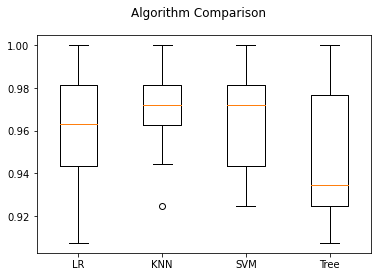

In [98]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('Tree', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle = True)
    cv_results = model_selection.cross_val_score(model, x_train_, y_train_, cv = kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Result:
Based on the result from KFold Cross Validation, KNN has the highest accuracy whereas Decision Tree has the lowest arruracy. 

## VIII . Tune hyperparameters (KNN, Logistic Regression, SVM)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best score of model: 0.9646590515749394 


best parameters of model: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'} 


                                              params  split0_test_score  \
8  {'metric': 'euclidean', 'n_neighbors': 11, 'we...           0.953704   
4  {'metric': 'euclidean', 'n_neighbors': 7, 'wei...           0.962963   
5  {'metric': 'euclidean', 'n_neighbors': 7, 'wei...           0.962963   
9  {'metric': 'euclidean', 'n_neighbors': 11, 'we...           0.953704   
7  {'metric': 'euclidean', 'n_neighbors': 9, 'wei...           0.953704   
6  {'metric': 'euclidean', 'n_neighbors': 9, 'wei...           0.953704   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
8           0.953704           0.981308           0.962617           0.971963   
4           0.953704           0.981308           0.962617           0.962617   
5           0.953704           0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


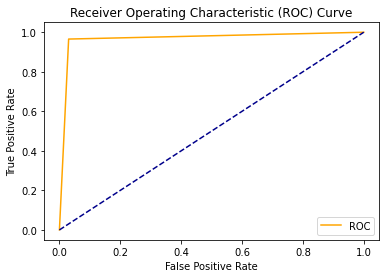

In [176]:
def Pipeline_KNN(X_train,y_train):
    knn = KNeighborsClassifier()
    #pipe.get_params().keys()
    param_grid = {
        'n_neighbors': [3,5,7,9,11], 
        'weights':['uniform','distance'], 
        'metric':['euclidean','manhattan']
    }

    grid_knn = GridSearchCV(knn, param_grid, verbose = 1, cv = 5, n_jobs = -1, scoring='accuracy')
    gs_knn_results = grid_knn.fit(X_train,y_train)
    return gs_knn_results


model_list_knn = ['KNN', Pipeline_KNN(x_train_, y_train_)]
statistic(model_list_knn[0], model_list_knn[1], x_test_, y_test_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best score of model: 0.966545517480097 


best parameters of model: {'C': 0.046415888336127774} 


                        params  split0_test_score  split1_test_score  \
1  {'C': 0.046415888336127774}           0.953704           0.944444   
2     {'C': 21.54434690031882}           0.944444           0.944444   
3               {'C': 10000.0}           0.944444           0.944444   
0                {'C': 0.0001}           0.805556           0.759259   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
1           0.981308           0.962617           0.990654         0.966546   
2           0.971963           0.962617           0.981308         0.960955   
3           0.971963           0.962617           0.981308         0.960955   
0           0.785047           0.813084           0.813084         0.795206   

   std_test_score  rank_test_score  
1        0.017135                1  
2        0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


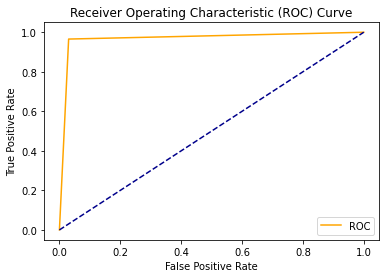

In [177]:
def Pipeline_Log(X_train, y_train):
    
    logistic = LogisticRegression()
    param_log = {'C': np.logspace(-4, 4, 4)}
    grid_log = GridSearchCV(logistic, param_log, verbose = 1, cv = 5, n_jobs = -1, scoring='accuracy')
    gs_log_results = grid_log.fit(X_train,y_train)
    return gs_log_results
    
model_list_log = ['Logistic Regression', Pipeline_Log(x_train_, y_train_)]
statistic(model_list_log[0], model_list_log[1], x_test_, y_test_)

best score of model: 0.9665455174800968 


best parameters of model: {'model': SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'model__C': 0.1, 'model__degree': 1} 


                                               params  split0_test_score  \
38  {'model': SVC(C=0.1, break_ties=False, cache_s...           0.944444   
45  {'model': SVC(C=0.1, break_ties=False, cache_s...           0.962963   
0   {'model': SVC(C=1.0, break_ties=False, cache_s...           0.944444   
2   {'model': SVC(C=1.0, break_ties=False, cache_s...           0.944444   
59  {'model': SVC(C=0.1, break_ties=False, cache_s...           0.944444   
5   {'model': SVC(C=1.0, break_ties=False, cache_s...           0.953704   

    split1_test_score  split2_test_score  split3_test_score  \
38           0.953704           0

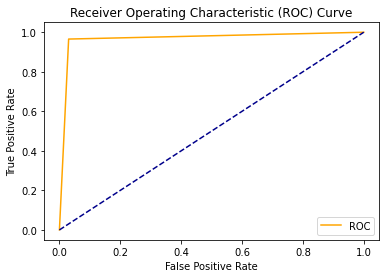

In [178]:
def Pipeline_SVM(X_train, y_train):
    
   
    pipe = Pipeline([('model', 'passthrough',),])
    param_grid = [{
            'model':(SVC(kernel = 'linear'),), # linear model
            'model__C': (0.001,0.1,1,10,100,1000,),
        },{
            'model':(SVC(kernel = 'rbf'),), # Gaussian model
            'model__C': (0.001,0.1,1,10,100,1000,),
            'model__gamma':(0.1, 1, 10, 100,),
        },{
            'model':(SVC(kernel = 'poly'),), # poly model
            'model__C': (0.001,0.1,1,10,100,1000,),
            'model__degree':(0, 1, 2, 3, 4, 5, 6,),
        }          
        
    ]
    
    pipe.steps
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy')
    gs_results = grid.fit(X_train,y_train)
    return gs_results

model_list_svm = ['SVM', Pipeline_SVM(x_train_, y_train_)]
statistic(model_list_svm[0], model_list_svm[1], x_test_, y_test_)

## IX.  Decision Tree, Random Forest and Gradient Boosting on processed data

In [ ]:
# Decision Tree
def tree_processed(x_train, y_train):
    
    tree = DecisionTreeClassifier()
    p_tree = {
    'criterion': ('gini','entropy'),
    'min_samples_split': range(200,1001,200),
    'max_depth': range(5,15,2),
    'min_samples_leaf': range(1,20,5),
    'max_features': ['log2','sqrt']}

    tree_ = GridSearchCV(estimator = tree, param_grid = p_tree, 
                   cv = 5,
                   n_jobs = -1, 
                   verbose = 0)
    tree_model = tree_.fit(x_train, y_train)
    return tree_model

statistic(tree_processed(x_train_, y_train_), x_test_, y_test_)

best score of model: 0.9665109034267912 


best parameters of model: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 200} 


                                                params  split0_test_score  \
0    {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.962963   
125  {'criterion': 'gini', 'max_depth': 11, 'max_fe...           0.962963   
156  {'criterion': 'gini', 'max_depth': 11, 'max_fe...           0.962963   
205  {'criterion': 'entropy', 'max_depth': 5, 'max_...           0.962963   
215  {'criterion': 'entropy', 'max_depth': 5, 'max_...           0.962963   
175  {'criterion': 'gini', 'max_depth': 13, 'max_fe...           0.925926   

     split1_test_score  split2_test_score  split3_test_score  \
0             0.953704           0.990654           0.962617   
125           0.953704           0.990654           0.962617   
156           0.953704           0.990654           0.962617   
205           0.96296

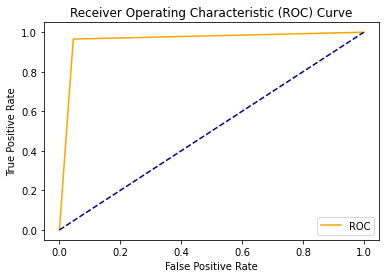

In [179]:
model_list_tree_p = ['Decision Tree(data cleaning)', tree_processed(x_train_, y_train_)]
statistic(model_list_tree_p[0], model_list_tree_p[1], x_test_, y_test_)

In [ ]:
# Random Forest
def forest_processed(x_train, y_train):
    RF = RandomForestClassifier()
    p_rf = {
    'n_estimators': [50,100,200,300],
    'min_samples_split': range(200,1001,200),
    'max_depth': range(5,15,2),
    'min_samples_leaf': range(1,20,5),
    'max_features': ['log2','sqrt']}

    rff = GridSearchCV(estimator = RF, param_grid = p_rf, 
                   cv = 5,
                   n_jobs = -1, 
                   verbose = 0)
    rf_model = rff.fit(x_train, y_train)
    return rf_model


best score of model: 0.9702492211838006 


best parameters of model: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 200, 'n_estimators': 50} 


                                                params  split0_test_score  \
180  {'max_depth': 7, 'max_features': 'log2', 'min_...           0.962963   
80   {'max_depth': 5, 'max_features': 'sqrt', 'min_...           0.962963   
0    {'max_depth': 5, 'max_features': 'log2', 'min_...           0.962963   
601  {'max_depth': 11, 'max_features': 'sqrt', 'min...           0.962963   
223  {'max_depth': 7, 'max_features': 'log2', 'min_...           0.962963   
602  {'max_depth': 11, 'max_features': 'sqrt', 'min...           0.962963   

     split1_test_score  split2_test_score  split3_test_score  \
180           0.953704           0.990654           0.962617   
80            0.935185           0.990654           0.962617   
0             0.944444           0.990654           0.962617   
601           0.944444

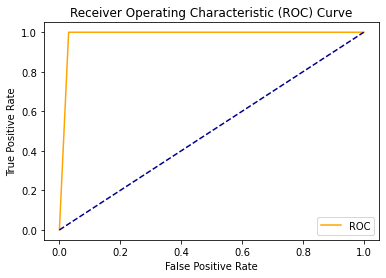

In [180]:
model_list_forest_p = ['Random Forest(data cleaning)', forest_processed(x_train_, y_train_)]
statistic(model_list_forest_p[0], model_list_forest_p[1], x_test_, y_test_)

In [ ]:
def gradient_processed(x_train, y_train):
    p_gb = {
    "loss":["deviance"], 
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 20, 30]}

    gb = GridSearchCV(estimator = GradientBoostingClassifier(), 
                  param_grid = p_gb, 
                  cv = 5, 
                  verbose = 0, 
                  n_jobs=-1)
    gb_model = gb.fit(x_train, y_train)
    return gb_model

best score of model: 0.9758047767393562 


best parameters of model: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.17272727272727273, 'min_samples_split': 0.2090909090909091, 'n_estimators': 30, 'subsample': 0.95} 


                                                  params  split0_test_score  \
82234  {'criterion': 'friedman_mse', 'learning_rate':...           0.972222   
58435  {'criterion': 'friedman_mse', 'learning_rate':...           0.962963   
48400  {'criterion': 'friedman_mse', 'learning_rate':...           0.972222   
84683  {'criterion': 'friedman_mse', 'learning_rate':...           0.972222   
79123  {'criterion': 'friedman_mse', 'learning_rate':...           0.972222   
66568  {'criterion': 'friedman_mse', 'learning_rate':...           0.972222   

       split1_test_score  split2_test_score  split3_test_score  \
82234           0.972222           0.990654           0.962617   
58435    

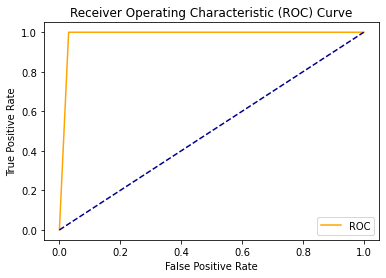

In [181]:
model_list_gb_p = ['Gradient Boosting(data cleaning)', gradient_processed(x_train_, y_train_)]
statistic(model_list_gb_p[0], model_list_gb_p[1], x_test_, y_test_)

## X. Statistics Analysis:

<Figure size 864x864 with 0 Axes>

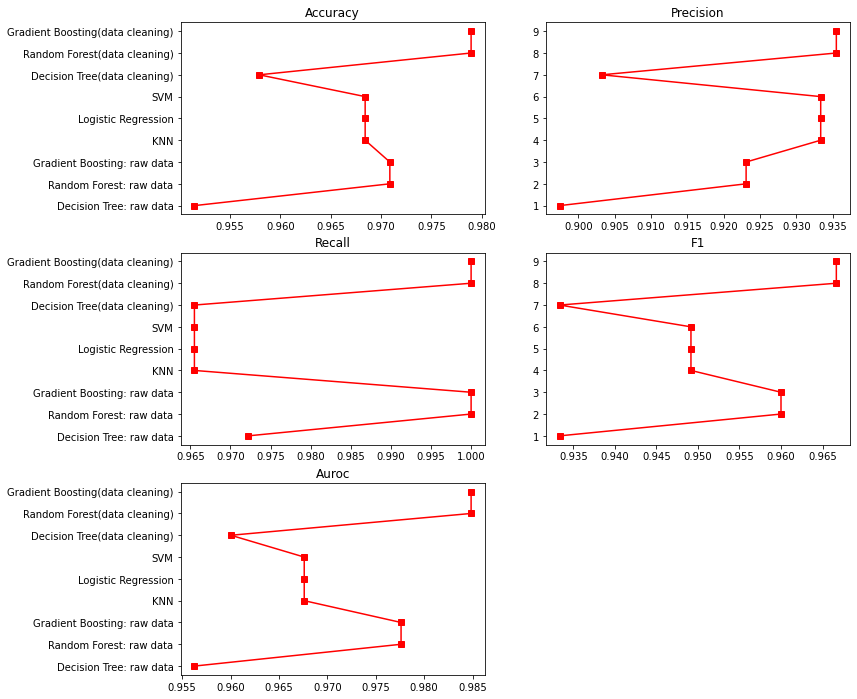

In [220]:
plt.figure(figsize=(12,12))
x_label = list(stat_dict.keys())
stat = ['Accuracy', 'Precision', 'Recall', 'F1', 'Auroc']
value = list(stat_dict.values())
acc = []
pre = []
recall = []
f1 = []
auroc = []
for elem in value:
    acc.append(elem[0])
    pre.append(elem[1])
    recall.append(elem[2])
    f1.append(elem[3])
    auroc.append(elem[4])

y_list = [acc, pre, recall, f1, auroc]
# plot figure:
plt.figure(figsize=(12,12))
y = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in range(len(stat)):
    plt.subplot(3, 2, i+1)
    plt.title(stat[i])
    plt.plot(y_list[i], y ,'s-',color = 'r',label="ATT-RLSTM" )
    if (i+1)%2:
        plt.yticks(y, x_label)
plt.show()

## VI. Conclusion

### Based on result of accuracy, the rank of model:    
1. Random Forest/ Gradient Boosting with data pre-processing;     
2. Random Forest/ Gradient Boosting with raw data;     
3. KNN/ Logistic Regression/ SVM;     
4. Decision Tree with data pre-processing;     
5. Decision Tree with raw data.

### Random forest and Gradient boosting performances best compared to other classifiers.

### Feature importance from Random Forest:    
1. Uniformity of Cell Shape;    
2. Bare Nuclei;     
3. Uniformity of Cell Size;    
4. Normal Nucleoli;     
5. Bland Chromatin;        
6. Single Epithelial Cell Size;       
7. Clump Thickness;           
8. Marginal Adhension;           
9. Mitoses

## VII. Related Iteratures

#### 1. Application of Decision Tree-Based Ensemble Learning in the Classification of Breast Cancer

Mohammad M. Ghiasi, Sohrab Zendehboudi

PII: S0010-4825(20)30420-0

DOI: https://doi.org/10.1016/j.compbiomed.2020.104089

Computers in Biology and Medicine

Model: Random Forest

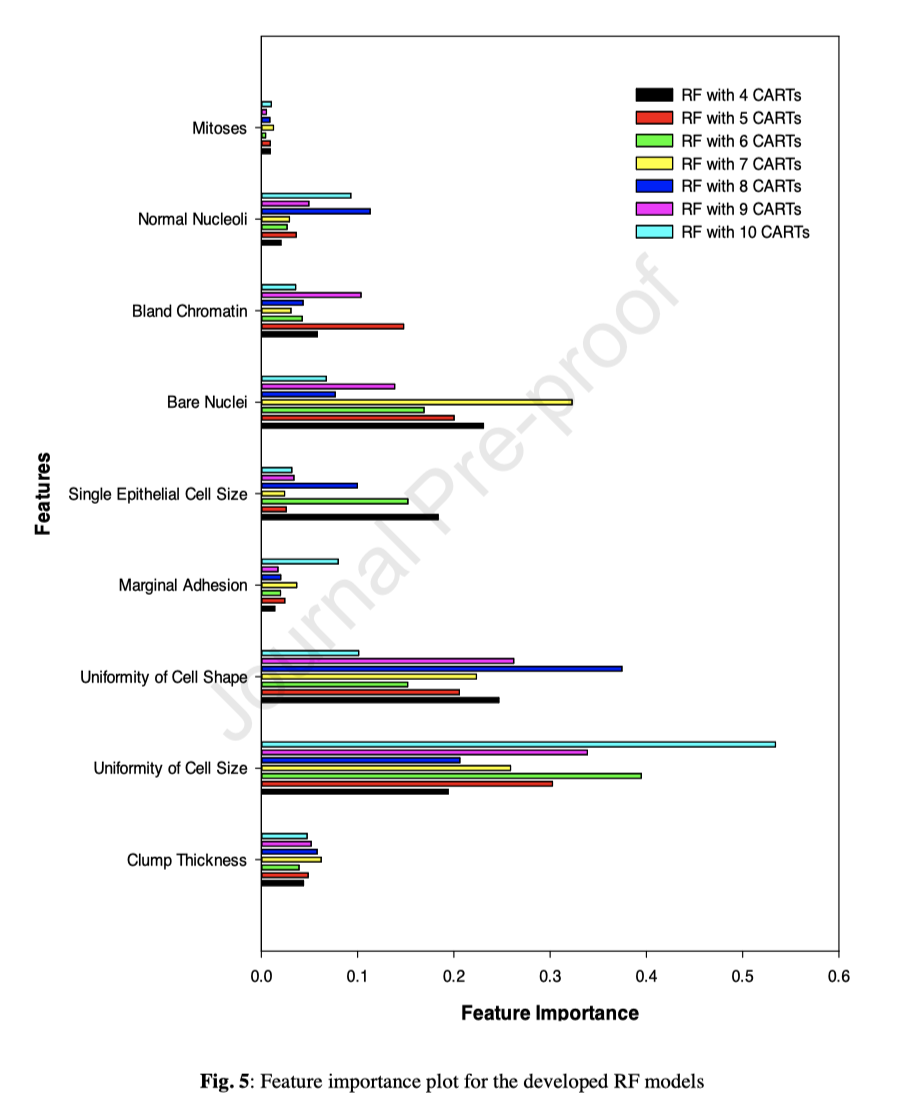

The mitoses factor shows the lowest importance, the uniformity of cell size is the most important/influential variable in the construction of the RF models with five, six, nine, and ten CARTs. In the case of the RF models with four and eight CARTs, the most important parameter is the uniformity of cell shape. On the other hand, the bare nuclei is considered as the most influencing factor in the RF model with seven CARTs.

#### 2. Quantitative analysis of breast cancer diagnosis using a probabilistic modelling approach
ShuoLiu et al.     
https://doi.org/10.1016/j.compbiomed.2017.11.014     
Computers in Biology and Medicine

Model: Bayesian network (BN) modelling approach

Bare nuclei is the most important discriminating feature of malignant and benign breast tumours, and uniformity of both cell size and cell shape are tightly interdependent.

## Result: Algorithms with calibrated probability

### Why Calibrated probability is used?
AUROC and AUPC are generated based on the predicted probability of given class. For some algorithm, Support Vector Machines, Decision Trees, Ensembles of Decision Trees (bagging, random forest, gradient boosting) and k-Nearest Neighbors, they do not predict a probability-like score, so they must be coerced in order to produce a probability-like score. As such, these algorithms often require their “probabilities” to be calibrated prior to use.

There are two main techniques for scaling predicted probabilities:
1. Platt Scaling: Logistic regression model to transform probabilities.
2. Isotonic Regression: Weighted least-squares regression model to transform probabilities.


Platt Scaling is most effective when the distortion in the predicted probabilities is sigmoid-shaped. Isotonic Regression is a more powerful calibration method that can correct any monotonic distortion.

In [ ]:

# decision tree with calibrated probabilities for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = DecisionTreeClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
# grid search 

In [ ]:

# grid search probability calibration with knn for imbalance classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = KNeighborsClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model)
# define grid
param_grid = dict(cv=[2,3,4], method=['sigmoid','isotonic'])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
cv = KFold(n_splits = 5, shuffle=True, random_state=1)

RF = RandomForestClassifier(min_samples_split = 100)
p_rf = {'n_estimators':[50,100,200,300,500],
        'max_depth':[10, 20, 30, 40, 50],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['log2','sqrt']}

rff = GridSearchCV(estimator = RF, param_grid = p_rf, 
                   cv = cv,
                   n_jobs = -1, 
                   verbose = 0)
rff.fit(feature,label)
rf_accuracy = cross_val_score(estimator = rff,
                            X = feature, 
                            y = label,
                            cv = cv, 
                            method='accuracy')
print(rf_accuracy)